## Overview

We have data that is distributed similar to a poisson distribution with mean ~3. We will try using linear regression but we need to make sure that the errors are distributed normally

We will create a 25% test set, and then use k-fold cross validation on the training set. Before then, we need to clean the data a little more

## Key columns

the key columns to use are (all normalised to a 38 game season, all last year excpet dependent variables): 

IVs

- npg_LY_norm = non-penalty goals 

- xG_LY_norm - expected goals based on chances 

- npxG_norm = non-penalty goals based on chances

- time_LY_norm = minutes played

- pen_goals_LY_norm = number of penalties scored.

- changed_league

- position

There are a number of key relationships between these variables. 

1) pen goals + np goals = goals, so we can remove goals.

2) xG is very closely correlated with goals scored, with the difference being measured as 'finishing' ability. Therefore, we can create a number of significantly less correlated variables, by stripping out the goalscoring into:

a) non-penalty xG

b) penalty xG

c) penalty finishing ability (penalties scored - non-penalty XG)

d) non-penalty finishing ability (non-pen goals - non-pen xG)

In [12]:
import pandas as pd 
import numpy as np 
import plotly 
from plotly import subplots 
from plotly import graph_objects as Go
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import statsmodels
import warnings
warnings.simplefilter('ignore')

In [13]:
#Load file in
df = pd.read_csv('csv_for_lin_reg_scoring')

In [52]:
y=df['goals']

In [15]:
cols = ['xG_LY_norm', 'npxG_LY_norm','changed_league', 'pen_goals_LY_norm','npg_LY_norm','time_LY_norm']
x = df[cols]
x['pen_XG_LY_norm'] = x['xG_LY_norm'] - x['npxG_LY_norm']
x['pen_finishing'] = x['pen_goals_LY_norm'] - x['pen_XG_LY_norm'] #this one is minus because otherwise we have to give non pen takers a 1, which is weird.
x['npen_finishing'] = x['npg_LY_norm'] - x['npxG_LY_norm']
x=x.drop(columns=['xG_LY_norm','pen_goals_LY_norm','npg_LY_norm'])
x.describe()

,npxG_LY_norm,time_LY_norm,pen_XG_LY_norm,pen_finishing,npen_finishing
count,10904.000000,10904.000000,10904.000000,10904.000000,10904.000000
mean,2.227489,1690.271042,0.207036,0.004675,-0.000229
std,3.258836,978.251881,0.749337,0.226684,1.342046
min,0.000000,1.000000,0.000000,-2.823711,-12.419626
25%,0.230634,888.397059,0.000000,0.000000,-0.554340
50%,1.048406,1714.000000,0.000000,0.000000,-0.055422
75%,2.807816,2491.235294,0.000000,0.000000,0.419866
max,38.454934,4641.428571,11.419401,2.580599,9.719091


In [16]:
#there aare now a lot of nulls because we had a lot of 0 div 0, which we can replace with 1
x=x.fillna(1)
#Converted changed league to a 1 / 0 
x['changed_league'] = x.loc[:,'changed_league'].astype('int')

,npxG_LY_norm,changed_league,time_LY_norm,pen_XG_LY_norm,pen_finishing,npen_finishing
count,1.090400e+04,1.090400e+04,1.090400e+04,1.090400e+04,1.090400e+04,1.090400e+04
mean,-1.954905e-18,2.606540e-17,-4.066202e-16,8.601581e-17,-4.561445e-18,2.280722e-18
std,1.000046e+00,1.000046e+00,1.000046e+00,1.000046e+00,1.000046e+00,1.000046e+00
min,-6.835543e-01,-3.313938e-01,-1.726905e+00,-2.763042e-01,-1.247778e+01,-9.254502e+00
25%,-6.127792e-01,-3.313938e-01,-8.197385e-01,-2.763042e-01,-2.062610e-02,-4.129042e-01
50%,-3.618279e-01,-3.313938e-01,2.425760e-02,-2.763042e-01,-2.062610e-02,-4.112784e-02
75%,1.780860e-01,-3.313938e-01,8.188085e-01,-2.763042e-01,-2.062610e-02,3.130405e-01
max,1.111719e+01,3.017558e+00,3.016905e+00,1.496373e+01,1.136401e+01,7.242499e+00


Std is 1 for all categories, with a mean of ~0

## CREATE TRAIN TEST SPLIT

In [60]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25)

In [61]:
#then scale the data
scaler = StandardScaler().fit(x_train)
x_train = pd.DataFrame(scaler.transform(x_train),columns=x.columns)
pd.DataFrame(columns=x.columns,data=x_train).describe()

,npxG_LY_norm,changed_league,time_LY_norm,pen_XG_LY_norm,pen_finishing,npen_finishing
count,8.178000e+03,8.178000e+03,8.178000e+03,8.178000e+03,8.178000e+03,8.178000e+03
mean,1.064337e-16,1.563924e-17,7.254869e-17,-5.734387e-17,5.191358e-17,8.688466e-19
std,1.000061e+00,1.000061e+00,1.000061e+00,1.000061e+00,1.000061e+00,1.000061e+00
min,-6.835810e-01,-3.317914e-01,-1.719076e+00,-2.800092e-01,-1.242972e+01,-9.416588e+00
25%,-6.132304e-01,-3.317914e-01,-8.154805e-01,-2.800092e-01,-1.303112e-02,-4.133315e-01
50%,-3.596763e-01,-3.317914e-01,1.777612e-02,-2.800092e-01,-1.303112e-02,-3.827027e-02
75%,1.809033e-01,-3.317914e-01,8.126280e-01,-2.800092e-01,-1.303112e-02,3.252234e-01
max,1.116319e+01,3.013942e+00,3.029586e+00,1.296168e+01,9.510852e+00,7.310624e+00


Perform basic linear regression with cross validation

In [62]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import r2_score

In [63]:
#We can use the built in 'cross val predict' initially to get predictions for all the validation groups
predictions = cross_val_predict(LinearRegression(),x_train,y_train,cv = 5)
print(f'This gives an r_squred of: {round(r2_score(y_train, predictions),2)}')
#Let's plot this, and the distribution of the errors
errors = predictions - y_train

This gives an r_squred of: 0.51


In [64]:
#Let's plot this, and the distribution of the errors
errors = predictions - y_train

In [65]:
fig = Go.Figure(data=Go.Histogram(x=errors))
fig.update_layout(title='error distribution')
fig.show()


In [66]:
def scatter(predictions, y_train, errors):
    fig = plotly.subplots.make_subplots(rows=1, cols=2)
    scat_1 = Go.Scatter(x=predictions, y=y_train, mode='markers')
    scat_2 = Go.Scatter(x=predictions, y=errors, mode='markers')
    fig.add_trace(scat_1,row=1, col=1)
    fig.add_trace(scat_2,row=1, col=2)
    fig['layout']['yaxis2'].update(title='Error')
    fig['layout']['yaxis1'].update(title='Actual goals')
    fig.update_xaxes(title='Predicted goals')
    fig.update_layout(width=750,height=400,showlegend=False)
    fig.show()
scatter(predictions,y_train,errors)

## There is significant overestimation at the lower end, and underestimation at the top end. 



In [67]:
import statsmodels.api as sm 

In [68]:
x_train_c = sm.add_constant(x_train)

In [69]:
y_train

3153    1
9432    0
4528    2
7306    3
3419    3
       ..
801     3
3668    0
8798    2
7054    1
5821    3
Name: goals, Length: 8178, dtype: int64

In [72]:
y_train = y_train.reset_index()
y_train.drop(columns=['level_0','index'],inplace=True)

In [73]:
ols = sm.OLS(y_train, x_train_c).fit()
print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:                  goals   R-squared:                       0.510
Model:                            OLS   Adj. R-squared:                  0.510
Method:                 Least Squares   F-statistic:                     1420.
Date:                Tue, 01 Jun 2021   Prob (F-statistic):               0.00
Time:                        14:22:28   Log-Likelihood:                -19439.
No. Observations:                8178   AIC:                         3.889e+04
Df Residuals:                    8171   BIC:                         3.894e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              2.1001      0.029     72.

Good news. We have a very significant F-Statistic, and all terms are significant. But r squared is low, only accounting for half the variance

## Add in Position

We have skewed errors (-1.83) and skewed Y distribution. We may be able to add some positional information in, starting with goalkeeper and striker, to remove some of that error (as it will decrease the high number of small overestimations (goalkeepers))

In [26]:
pd.DataFrame(df['position'].T.value_counts())

,position
M S,2216
D S,2030
F M S,1661
D M S,1011
F S,1002
D,917
GK,711
S,474
M,259
D M,202


let's create two columns - 1) contains S for striker but not defender (for a very offensive player) and contains just GK (we'll leave out GK S because that's probably strikers who had to go in goal for a weird reason.)

In [31]:
striker_tags = ['M S', 'F M S','F S','S']
GK_tag = ['GK']

In [32]:
df['strikers'] = df['position'].apply(lambda x: 1 if x in striker_tags else 0)
df['GK'] = df['position'].apply(lambda x: 1 if x in GK_tag else 0)

In [33]:
#now apply this to our previously made x_col
x['strikers'] = df['strikers']
x['GK'] = df['GK']

In [94]:
def x_y_scale_split_ols(x,y):
    
    x_train_2, x_test_2, y_train_2, y_test_2 = train_test_split(x, y, test_size = 0.25)
    scaler = StandardScaler().fit(x_train_2)
    x_norm_2 = scaler.transform(x_train_2)
    x_norm_2 = pd.DataFrame(columns=x.columns,data=x_norm_2)
    x_train_2 = sm.add_constant(x_train_2)
    ols_output = sm.OLS(y_train_2, x_train_2).fit()
    return ols_output, scaler, x_train_2, y_train_2
output, new_scaler, x_train_2_,y_train_2 = x_y_scale_split_ols(x,y)
print(output.summary())

                            OLS Regression Results                            
Dep. Variable:                  goals   R-squared:                       0.531
Model:                            OLS   Adj. R-squared:                  0.530
Method:                 Least Squares   F-statistic:                     1155.
Date:                Fri, 28 May 2021   Prob (F-statistic):               0.00
Time:                        11:23:05   Log-Likelihood:                -19357.
No. Observations:                8178   AIC:                         3.873e+04
Df Residuals:                    8169   BIC:                         3.879e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.7557      0.071     10.

Despite striker being significant, we haven't added a significant amount of power, and we still have this skew issue. We have two very clearly skewed columns - goals and npxG_LY_norm

## Normalising goals and npxG_LY_norm using logs

In [38]:
print(f'Current skew is {y.skew()}')

Current skew is 3.5251373924238827


In [37]:
print(f'Skew Log1p y: {np.log1p(y).skew()}')
npxg=x['npxG_LY_norm']
print(f'Skew Log1p npxg: {np.log1p(npxg).skew()}')

Skew Log1p y: 0.8986929636252532
Skew Log1p npxg: 0.7690627827419312


Let's try that in the model and see if things improve

In [40]:
x_log = x.copy()
x_log['npxG_LY_norm_log'] = np.log1p(x_log['npxG_LY_norm'])
x_log.drop(columns='npxG_LY_norm',inplace=True)
y_log = np.log1p(y)

In [42]:
output_log, scalar_log, x_train_3 = x_y_scale_split_ols(x_log,y_log)
print(output_log.summary())

                            OLS Regression Results                            
Dep. Variable:                  goals   R-squared:                       0.456
Model:                            OLS   Adj. R-squared:                  0.456
Method:                 Least Squares   F-statistic:                     857.2
Date:                Fri, 28 May 2021   Prob (F-statistic):               0.00
Time:                        10:40:47   Log-Likelihood:                -7512.9
No. Observations:                8178   AIC:                         1.504e+04
Df Residuals:                    8169   BIC:                         1.511e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.1897      0.017  

Skew has gone and it then got worse!!

Looks worse - let's take a look at the errors here - turns out they're also normally distributed but with a higher standard deviation

In [44]:
#We can use the built in 'cross val predict' initially to get predictions for all the validation groups
predictions = cross_val_predict(LinearRegression(),x_log,y_log,cv = 5)
print(f'This gives an r_squred of: {round(r2_score(y_log, predictions),2)}')
#Let's plot this, and the distribution of the errors
errors = predictions - y_log

This gives an r_squred of: 0.45


In [40]:
fig = Go.Figure(data=Go.Histogram(x=errors))
fig.show()

And our errors look kind of weird - it suggests we haven't extracted all the information. We could try a polynomial feature set, or a decision tree regressor

In [45]:
scatter(predictions,y_log,errors)

In [204]:
corr_df = pd.merge(x,y,left_index=True,right_index=True)

In [207]:
corr_df.corr()


,npxG_LY_norm,changed_league,time_LY_norm,pen_XG_LY_norm,pen_finishing,npen_finishing,strikers,GK,goals
npxG_LY_norm,1.000000,0.012548,0.334070,0.514834,0.052442,0.077382,0.353850,-0.180153,0.705045
changed_league,0.012548,1.000000,-0.051301,0.006533,-0.002131,0.001341,0.051789,-0.020348,-0.000477
time_LY_norm,0.334070,-0.051301,1.000000,0.210865,0.024250,0.053367,-0.169968,0.113982,0.166034
pen_XG_LY_norm,0.514834,0.006533,0.210865,1.000000,0.233367,0.081650,0.178010,-0.072975,0.458534
pen_finishing,0.052442,-0.002131,0.024250,0.233367,1.000000,0.002389,0.017127,-0.005448,0.099326
npen_finishing,0.077382,0.001341,0.053367,0.081650,0.002389,1.000000,0.036620,-0.000569,0.098275
strikers,0.353850,0.051789,-0.169968,0.178010,0.017127,0.036620,1.000000,-0.259356,0.288059
GK,-0.180153,-0.020348,0.113982,-0.072975,-0.005448,-0.000569,-0.259356,1.000000,-0.148441
goals,0.705045,-0.000477,0.166034,0.458534,0.099326,0.098275,0.288059,-0.148441,1.000000


We can see that changed_league has a very low coefficient, to goals. it's p value matches roughly the chi squared value we got before.

for GK, we can assume that it is colinear with a number of other variables added together.

## Decision Tree Regressor

We can use the non scaled data for Decision Trees, which will also make the model more interpretable

In [86]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score

In [96]:
x_dt_train, x_dt_test, y_dt_train, y_dt_test = train_test_split(x,y)

In [84]:
tree = DecisionTreeRegressor(max_leaf_nodes=20).fit(x_train_2,y_train_2)
print(tree.score(x_train_2,y_train_2))
preds = tree.predict(x_train_2)
r2_score(preds,y_train_2)

0.044209785791415435


-20.619426493447953

In [106]:
tree_df = pd.DataFrame(columns=['max_features','r2'])
for alpha in max_features:
    tree = DecisionTreeRegressor(max_leaf_nodes=int(alpha))
    preds_dt = cross_val_predict(tree,x_dt_train,y_dt_train,cv=5)
    r2=round(r2_score(y_dt_train, preds_dt),3)
    tree_df = tree_df.append(pd.DataFrame({'max_features':int(alpha),'r2':r2},index=[alpha]))

print(f'Best Performance scores is: {np.max(tree_df["r2"])}')
best_alpha = int(tree_df[tree_df['r2'] == np.max(tree_df['r2'])]['max_features'])
print(f"This is with {best_alpha} features")
tree_df.T

Best Performance scores is: 0.476
This is with 9 features


,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,...,21.0,22.0,23.0,24.0,25.0,26.0,27.0,28.0,29.0,30.0
max_features,5,6,7,8,9,10,11,12,13,14,...,21,22,23,24,25,26,27,28,29,30
r2,0.456,0.461,0.471,0.472,0.476,0.474,0.473,0.471,0.469,0.465,...,0.462,0.459,0.451,0.456,0.459,0.454,0.46,0.454,0.451,0.454


## Worse rSquared but maybe a simpler model. Let's look at what the decision tree looks like

In [114]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plta

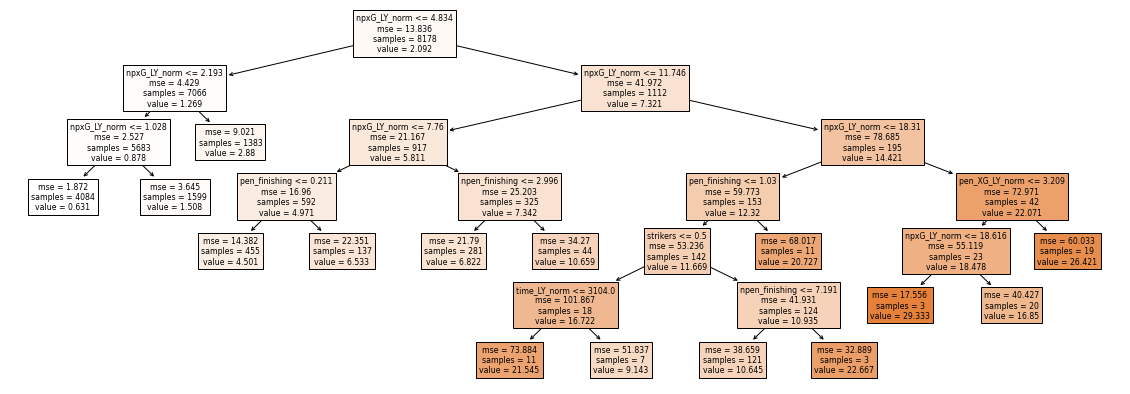

In [121]:
tree = DecisionTreeRegressor(max_leaf_nodes=15).fit(x_dt_train,y_dt_train)
fig = plt.figure(figsize=(20,7))
fig = plot_tree(tree,
            feature_names = x.columns,
            filled=True)


## Most of the nodes are one metric (npxg_LY_norm)

This is also the most powerful coefficient in the linear regression model.

Can we somehow combine the two?